# Basic Stocks Data Analysis

Experimenting with sample stocks trying to follow the "Stock Data Processing Plan for Portfolio Optimization"

## Phase 1: Data Validation & Cleaning

### Historical Data Processing
- **Date Range Validation**: Ensure consistent time periods across all stocks
- **Missing Data Handling**: 
  - Forward fill for minor gaps (1-3 days)
  - Flag stocks with excessive missing data (>5%)
  - Handle stock splits and dividend adjustments
- **Volume Validation**: Filter out stocks with consistently low volume (liquidity concerns)

### Fundamentals Data Processing
- **Data Availability Score**: Calculate percentage of non-null fundamental metrics
- **Sector/Industry Classification**: Handle missing classifications
- **Outlier Detection**: Identify and flag extreme fundamental ratios


Loaded 1254 days of AAPL data
Date range: 2020-09-01 to 2025-08-28

Sample of historical data:
                  Open        High         Low       Close    Volume
Date                                                                
2025-08-22  226.169998  229.089996  225.410004  227.759995  42477800
2025-08-25  226.479996  229.300003  226.229996  227.160004  30983100
2025-08-26  226.869995  229.490005  224.690002  229.309998  54575100
2025-08-27  228.610001  230.899994  228.259995  230.490005  31259500
2025-08-28  230.820007  233.410004  229.339996  232.559998  38074700

Fundamental metrics:
  Market Cap: 3445050310656
  P/E Ratio: 35.2261
  Forward P/E: 27.935017
  P/B Ratio: 52.389977
  EV/EBITDA: 24.64
  ROE: 1.49814
  ROA: 0.24545999
  Debt/Equity: 154.486
  Current Ratio: 0.868
  Quick Ratio: 0.724
  Revenue Growth: 0.096
  Earnings Growth: 0.121
  Beta: 1.165
  Dividend Yield: 0.45
  Sector: Technology
  Industry: Consumer Electronics


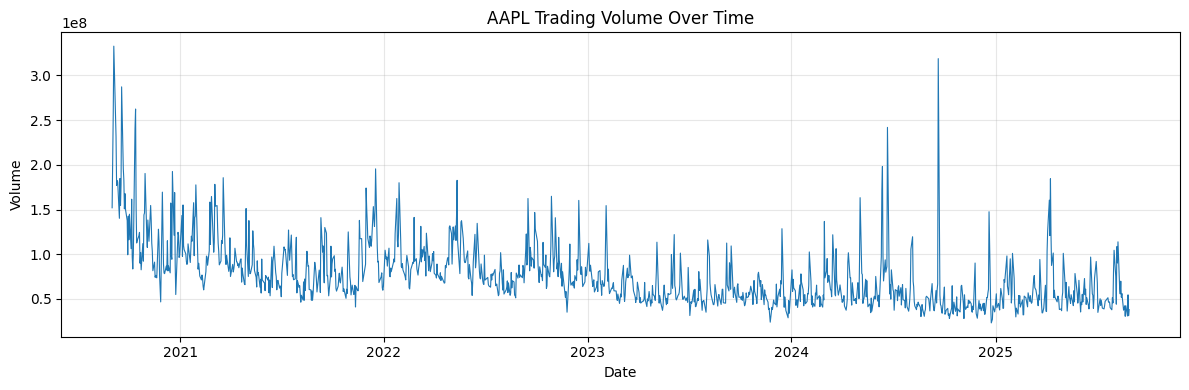

In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Load Apple stock data
ticker = "AAPL"
stock = yf.Ticker(ticker)

# Get 5 years of daily historical data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# Load historical daily data from local CSV
csv_path = "../../data/raw/historical/AAPL.csv"
hist_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')
# Filter to 5-year date range
hist_data = hist_data[(hist_data.index >= start_date) & (hist_data.index <= end_date)]

# Get fundamental data
info = stock.info
fundamentals = {
    'Market Cap': info.get('marketCap'),
    'P/E Ratio': info.get('trailingPE'),
    'Forward P/E': info.get('forwardPE'),
    'PEG Ratio': info.get('pegRatio'),
    'P/B Ratio': info.get('priceToBook'),
    'EV/EBITDA': info.get('enterpriseToEbitda'),
    'ROE': info.get('returnOnEquity'),
    'ROA': info.get('returnOnAssets'),
    'Debt/Equity': info.get('debtToEquity'),
    'Current Ratio': info.get('currentRatio'),
    'Quick Ratio': info.get('quickRatio'),
    'Revenue Growth': info.get('revenueGrowth'),
    'Earnings Growth': info.get('earningsGrowth'),
    'Beta': info.get('beta'),
    'Dividend Yield': info.get('dividendYield'),
    'Sector': info.get('sector'),
    'Industry': info.get('industry')
}

print(f"Loaded {len(hist_data)} days of {ticker} data")
print(f"Date range: {hist_data.index[0].date()} to {hist_data.index[-1].date()}")
print(f"\nSample of historical data:")
print(hist_data.tail())
print(f"\nFundamental metrics:")
for key, value in fundamentals.items():
    if value is not None:
        print(f"  {key}: {value}")

# Plot volume over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(hist_data.index, hist_data['Volume'], linewidth=0.8)
plt.title(f'{ticker} Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Phase 2: Feature Engineering

### Technical Indicators
- **Simple Moving Averages (SMA)**: 20, 50, 200-day SMAs for trend identification
- **Exponential Moving Average (EMA)**: 12, 26-day EMAs for MACD calculation
- **RSI (Relative Strength Index)**: Momentum oscillator (14-day period)
- **MACD**: Moving Average Convergence Divergence with signal line
- **Bollinger Bands**: Volatility bands (20-day SMA ± 2 std deviations)
- **Volume-Weighted Average Price (VWAP)**: Intraday benchmark

### Price-Based Features
- **Daily Returns**: Percentage change from previous close
- **Log Returns**: Natural log of price ratios
- **Rolling Volatility**: 20-day and 60-day standard deviation of returns
- **Price to SMA Ratios**: Current price relative to moving averages
- **Support/Resistance Levels**: Recent highs and lows

### Volume Features
- **Volume Moving Average**: 20-day average volume
- **Volume Ratio**: Current volume vs average volume
- **On-Balance Volume (OBV)**: Cumulative volume flow indicator

In [54]:
# Phase 2: Feature Engineering - Calculate Technical Indicators

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD indicator"""
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def calculate_bollinger_bands(prices, period=20, std_dev=2):
    """Calculate Bollinger Bands"""
    sma = prices.rolling(window=period).mean()
    std = prices.rolling(window=period).std()
    upper_band = sma + (std * std_dev)
    lower_band = sma - (std * std_dev)
    return upper_band, sma, lower_band

def calculate_obv(prices, volumes):
    """Calculate On-Balance Volume"""
    price_diff = prices.diff()
    volume_direction = np.where(price_diff > 0, volumes, 
                                np.where(price_diff < 0, -volumes, 0))
    obv = pd.Series(volume_direction, index=prices.index).cumsum()
    return obv

# Add technical indicators to the dataframe
hist_data_enhanced = hist_data.copy()

# Simple Moving Averages
hist_data_enhanced['SMA_20'] = hist_data_enhanced['Close'].rolling(window=20).mean()
hist_data_enhanced['SMA_50'] = hist_data_enhanced['Close'].rolling(window=50).mean()
hist_data_enhanced['SMA_200'] = hist_data_enhanced['Close'].rolling(window=200).mean()

# Exponential Moving Averages
hist_data_enhanced['EMA_12'] = hist_data_enhanced['Close'].ewm(span=12, adjust=False).mean()
hist_data_enhanced['EMA_26'] = hist_data_enhanced['Close'].ewm(span=26, adjust=False).mean()

# RSI
hist_data_enhanced['RSI'] = calculate_rsi(hist_data_enhanced['Close'])

# MACD
macd, signal, histogram = calculate_macd(hist_data_enhanced['Close'])
hist_data_enhanced['MACD'] = macd
hist_data_enhanced['MACD_Signal'] = signal
hist_data_enhanced['MACD_Histogram'] = histogram

# Bollinger Bands
upper, middle, lower = calculate_bollinger_bands(hist_data_enhanced['Close'])
hist_data_enhanced['BB_Upper'] = upper
hist_data_enhanced['BB_Middle'] = middle
hist_data_enhanced['BB_Lower'] = lower

# Price-based features
hist_data_enhanced['Daily_Return'] = hist_data_enhanced['Close'].pct_change()
hist_data_enhanced['Log_Return'] = np.log(hist_data_enhanced['Close'] / hist_data_enhanced['Close'].shift(1))
hist_data_enhanced['Volatility_20'] = hist_data_enhanced['Daily_Return'].rolling(window=20).std()
hist_data_enhanced['Volatility_60'] = hist_data_enhanced['Daily_Return'].rolling(window=60).std()

# Price to SMA ratios
hist_data_enhanced['Price_to_SMA20'] = hist_data_enhanced['Close'] / hist_data_enhanced['SMA_20']
hist_data_enhanced['Price_to_SMA50'] = hist_data_enhanced['Close'] / hist_data_enhanced['SMA_50']

# Volume features
hist_data_enhanced['Volume_MA'] = hist_data_enhanced['Volume'].rolling(window=20).mean()
hist_data_enhanced['Volume_Ratio'] = hist_data_enhanced['Volume'] / hist_data_enhanced['Volume_MA']
hist_data_enhanced['OBV'] = calculate_obv(hist_data_enhanced['Close'], hist_data_enhanced['Volume'])

# VWAP (simplified daily VWAP)
hist_data_enhanced['VWAP'] = (hist_data_enhanced['Close'] * hist_data_enhanced['Volume']).cumsum() / hist_data_enhanced['Volume'].cumsum()

print(f"Enhanced dataframe shape: {hist_data_enhanced.shape}")
print(f"New columns added: {len(hist_data_enhanced.columns) - len(hist_data.columns)}")
print(f"\nSample of enhanced data with indicators:")
print(hist_data_enhanced[['Close', 'SMA_20', 'RSI', 'MACD', 'Daily_Return', 'Volume_Ratio']].tail())

Enhanced dataframe shape: (1254, 27)
New columns added: 22

Sample of enhanced data with indicators:
                 Close      SMA_20        RSI      MACD  Daily_Return  \
Date                                                                    
2025-08-22  227.759995  220.273721  76.678976  5.222377      0.012717   
2025-08-25  227.160004  220.941353  76.396983  4.944021     -0.002634   
2025-08-26  229.309998  221.855328  71.347543  4.841103      0.009465   
2025-08-27  230.490005  222.939177  66.430828  4.799431      0.005146   
2025-08-28  232.559998  224.200442  56.844148  4.877216      0.008981   

            Volume_Ratio  
Date                      
2025-08-22      0.685541  
2025-08-25      0.502820  
2025-08-26      0.883423  
2025-08-27      0.511912  
2025-08-28      0.646067  


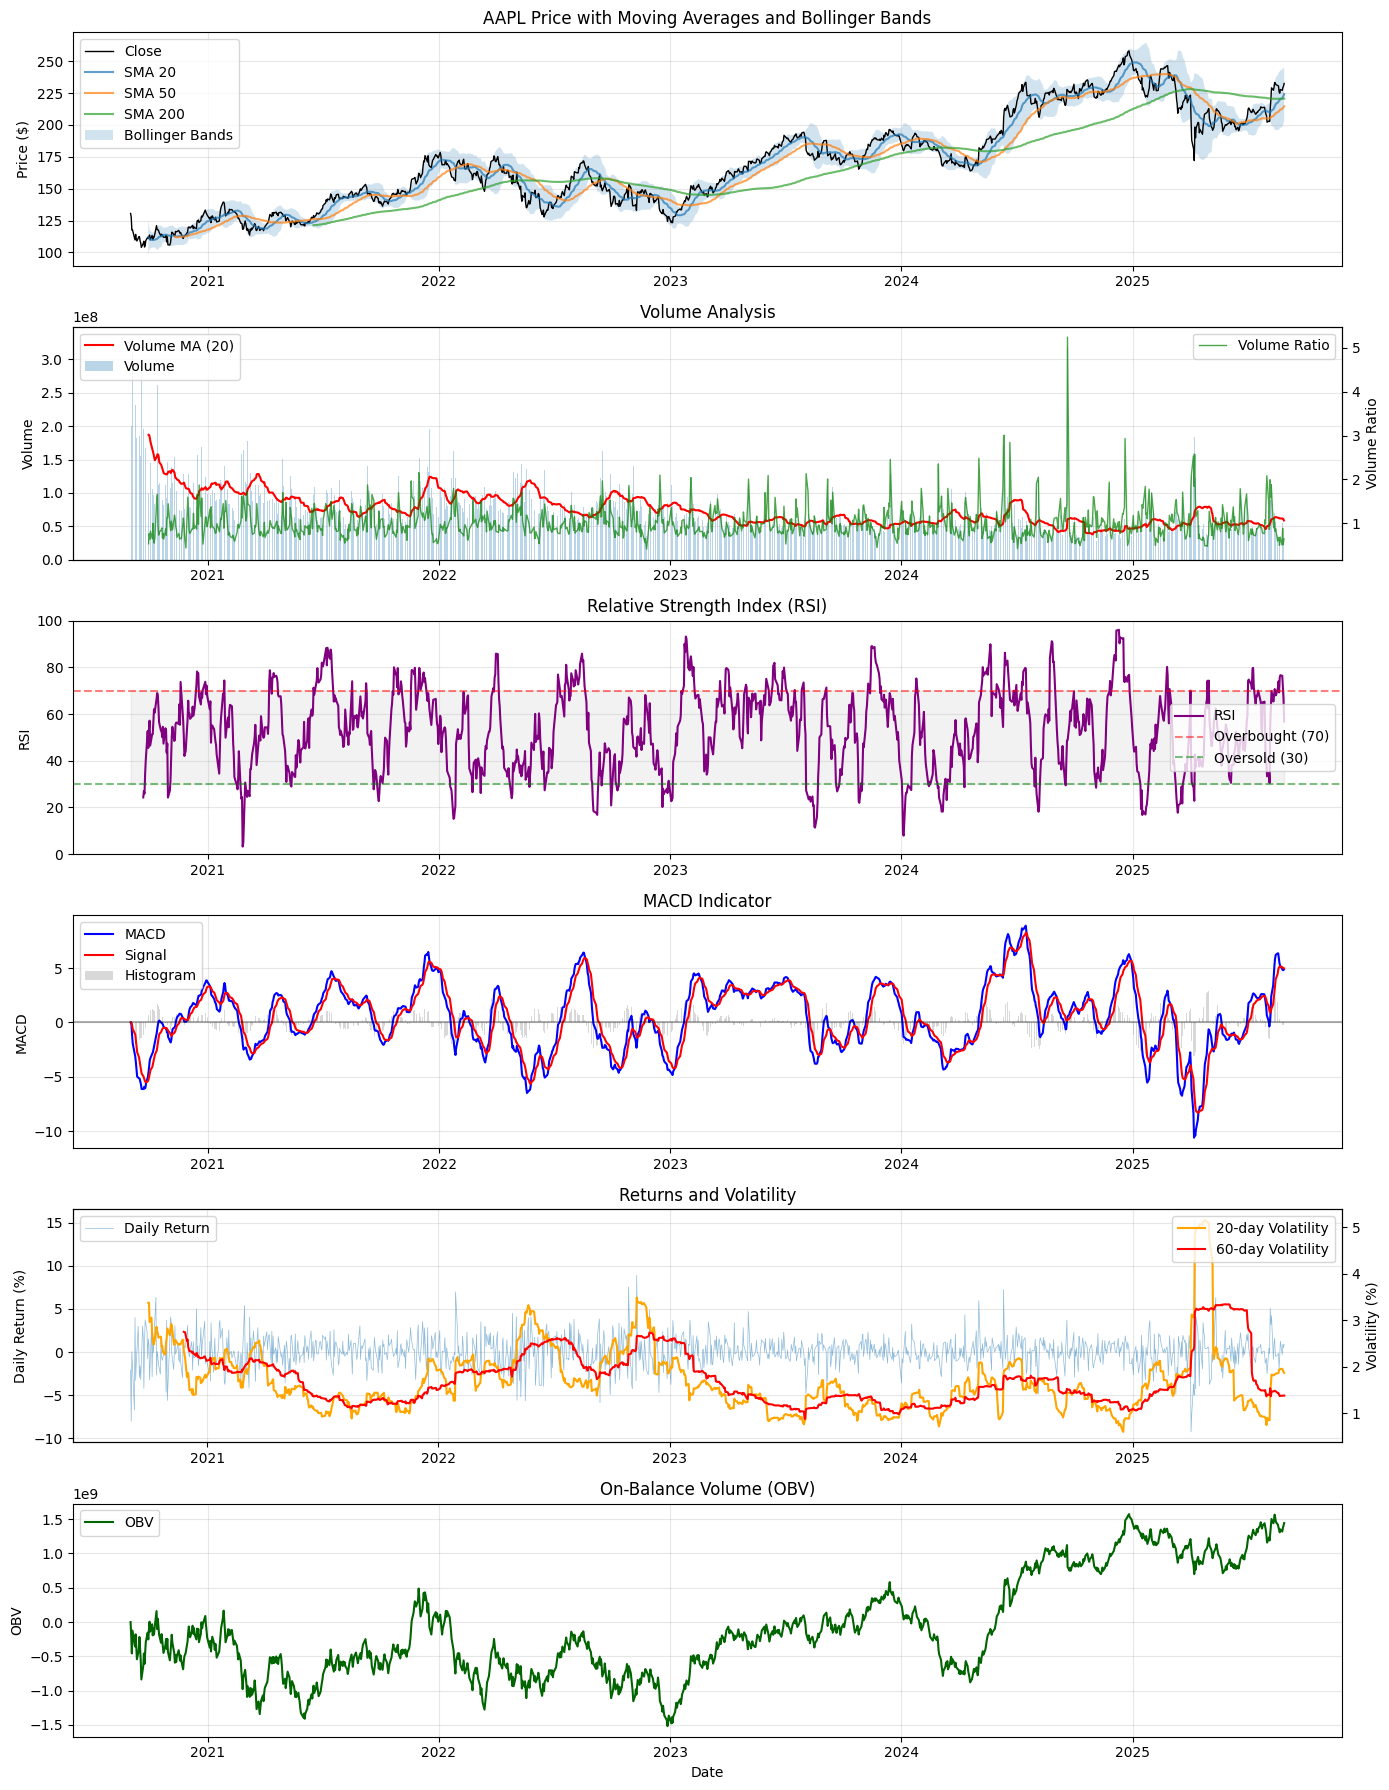


Statistical Summary of Key Indicators (last 252 trading days):
  Avg Daily Return: 0.031%
  Annualized Return: 7.86%
  Annualized Volatility: 32.05%
  Sharpe Ratio: 0.245
  Current RSI: 56.84
  Current MACD: 4.88
  Price vs SMA20: 3.73%
  Volume Ratio: 0.65x


In [55]:
# Visualize the calculated technical indicators

fig, axes = plt.subplots(6, 1, figsize=(14, 18))

# Plot 1: Price with Moving Averages and Bollinger Bands
ax1 = axes[0]
ax1.plot(hist_data_enhanced.index, hist_data_enhanced['Close'], label='Close', linewidth=1, color='black')
ax1.plot(hist_data_enhanced.index, hist_data_enhanced['SMA_20'], label='SMA 20', alpha=0.7)
ax1.plot(hist_data_enhanced.index, hist_data_enhanced['SMA_50'], label='SMA 50', alpha=0.7)
ax1.plot(hist_data_enhanced.index, hist_data_enhanced['SMA_200'], label='SMA 200', alpha=0.7)
ax1.fill_between(hist_data_enhanced.index, hist_data_enhanced['BB_Upper'], hist_data_enhanced['BB_Lower'], 
                  alpha=0.2, label='Bollinger Bands')
ax1.set_title(f'{ticker} Price with Moving Averages and Bollinger Bands')
ax1.set_ylabel('Price ($)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Volume with Volume MA and Volume Ratio
ax2 = axes[1]
ax2_twin = ax2.twinx()
ax2.bar(hist_data_enhanced.index, hist_data_enhanced['Volume'], alpha=0.3, label='Volume')
ax2.plot(hist_data_enhanced.index, hist_data_enhanced['Volume_MA'], color='red', label='Volume MA (20)', linewidth=1.5)
ax2_twin.plot(hist_data_enhanced.index, hist_data_enhanced['Volume_Ratio'], color='green', label='Volume Ratio', linewidth=1, alpha=0.7)
ax2.set_title('Volume Analysis')
ax2.set_ylabel('Volume')
ax2_twin.set_ylabel('Volume Ratio')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: RSI
ax3 = axes[2]
ax3.plot(hist_data_enhanced.index, hist_data_enhanced['RSI'], label='RSI', color='purple')
ax3.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
ax3.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
ax3.fill_between(hist_data_enhanced.index, 30, 70, alpha=0.1, color='gray')
ax3.set_title('Relative Strength Index (RSI)')
ax3.set_ylabel('RSI')
ax3.set_ylim(0, 100)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Plot 4: MACD
ax4 = axes[3]
ax4.plot(hist_data_enhanced.index, hist_data_enhanced['MACD'], label='MACD', color='blue')
ax4.plot(hist_data_enhanced.index, hist_data_enhanced['MACD_Signal'], label='Signal', color='red')
ax4.bar(hist_data_enhanced.index, hist_data_enhanced['MACD_Histogram'], label='Histogram', alpha=0.3, color='gray')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.set_title('MACD Indicator')
ax4.set_ylabel('MACD')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# Plot 5: Returns and Volatility
ax5 = axes[4]
ax5_twin = ax5.twinx()
ax5.plot(hist_data_enhanced.index, hist_data_enhanced['Daily_Return'] * 100, label='Daily Return', alpha=0.5, linewidth=0.5)
ax5_twin.plot(hist_data_enhanced.index, hist_data_enhanced['Volatility_20'] * 100, label='20-day Volatility', color='orange', linewidth=1.5)
ax5_twin.plot(hist_data_enhanced.index, hist_data_enhanced['Volatility_60'] * 100, label='60-day Volatility', color='red', linewidth=1.5)
ax5.set_title('Returns and Volatility')
ax5.set_ylabel('Daily Return (%)')
ax5_twin.set_ylabel('Volatility (%)')
ax5.legend(loc='upper left')
ax5_twin.legend(loc='upper right')
ax5.grid(True, alpha=0.3)

# Plot 6: On-Balance Volume
ax6 = axes[5]
ax6.plot(hist_data_enhanced.index, hist_data_enhanced['OBV'], label='OBV', color='darkgreen')
ax6.set_title('On-Balance Volume (OBV)')
ax6.set_ylabel('OBV')
ax6.set_xlabel('Date')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStatistical Summary of Key Indicators (last 252 trading days):")
recent_data = hist_data_enhanced.tail(252)
summary_stats = {
    'Avg Daily Return': f"{recent_data['Daily_Return'].mean() * 100:.3f}%",
    'Annualized Return': f"{recent_data['Daily_Return'].mean() * 252 * 100:.2f}%",
    'Annualized Volatility': f"{recent_data['Daily_Return'].std() * np.sqrt(252) * 100:.2f}%",
    'Sharpe Ratio': f"{(recent_data['Daily_Return'].mean() / recent_data['Daily_Return'].std()) * np.sqrt(252):.3f}",
    'Current RSI': f"{recent_data['RSI'].iloc[-1]:.2f}",
    'Current MACD': f"{recent_data['MACD'].iloc[-1]:.2f}",
    'Price vs SMA20': f"{(recent_data['Price_to_SMA20'].iloc[-1] - 1) * 100:.2f}%",
    'Volume Ratio': f"{recent_data['Volume_Ratio'].iloc[-1]:.2f}x"
}

for key, value in summary_stats.items():
    print(f"  {key}: {value}")

## Phase 3: Risk Metrics & Portfolio Analysis

### Risk Metrics
- **Value at Risk (VaR)**: Maximum potential loss at a confidence level (95%, 99%)
- **Conditional VaR (CVaR)**: Expected loss beyond VaR threshold
- **Maximum Drawdown**: Largest peak-to-trough decline
- **Beta**: Systematic risk relative to market
- **Downside Deviation**: Volatility of negative returns only

### Portfolio-Relevant Metrics
- **Correlation Matrix**: For diversification analysis
- **Rolling Correlations**: Time-varying relationships
- **Risk-Adjusted Performance**: Sharpe, Sortino, Calmar ratios
- **Drawdown Analysis**: Duration and recovery periods

In [56]:
# Phase 3: Risk Metrics Calculations

def calculate_var(returns, confidence_level=0.95):
    """Calculate Value at Risk using historical method"""
    return np.percentile(returns, (1 - confidence_level) * 100)

def calculate_cvar(returns, confidence_level=0.95):
    """Calculate Conditional Value at Risk (Expected Shortfall)"""
    var = calculate_var(returns, confidence_level)
    return returns[returns <= var].mean()

def calculate_drawdowns(prices):
    """Calculate drawdown series and statistics"""
    cumulative = (1 + prices.pct_change()).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    
    # Find maximum drawdown
    max_dd = drawdown.min()
    
    # Find drawdown periods
    drawdown_start = drawdown[drawdown == 0].index
    drawdown_periods = []
    
    for i in range(len(drawdown_start) - 1):
        period_dd = drawdown[drawdown_start[i]:drawdown_start[i+1]]
        if period_dd.min() < -0.05:  # Only significant drawdowns (>5%)
            drawdown_periods.append({
                'start': drawdown_start[i],
                'trough': period_dd.idxmin(),
                'end': drawdown_start[i+1],
                'depth': period_dd.min(),
                'duration': (drawdown_start[i+1] - drawdown_start[i]).days
            })
    
    return drawdown, max_dd, drawdown_periods

def calculate_beta(stock_returns, market_returns):
    """Calculate beta relative to market"""
    covariance = np.cov(stock_returns.dropna(), market_returns.dropna())[0, 1]
    market_variance = np.var(market_returns.dropna())
    return covariance / market_variance

def calculate_sortino_ratio(returns, target_return=0):
    """Calculate Sortino ratio using downside deviation"""
    excess_returns = returns - target_return
    downside_returns = excess_returns[excess_returns < 0]
    downside_deviation = np.sqrt((downside_returns ** 2).mean())
    return excess_returns.mean() / downside_deviation if downside_deviation != 0 else 0

def calculate_calmar_ratio(returns, prices):
    """Calculate Calmar ratio (annual return / max drawdown)"""
    annual_return = returns.mean() * 252
    _, max_dd = calculate_drawdowns(prices)[:2]
    return annual_return / abs(max_dd) if max_dd != 0 else 0

def calculate_rolling_beta(stock_returns, market_returns, window):
    """Calculate rolling beta with proper alignment"""
    rolling_betas = []
    for i in range(len(stock_returns)):
        if i < window - 1:
            rolling_betas.append(np.nan)
        else:
            window_stock = stock_returns.iloc[i-window+1:i+1].values
            window_market = market_returns.iloc[i-window+1:i+1].values
            if len(window_stock) == window and len(window_market) == window:
                cov = np.cov(window_stock, window_market)[0, 1]
                var = np.var(window_market)
                beta = cov / var if var != 0 else np.nan
                rolling_betas.append(beta)
            else:
                rolling_betas.append(np.nan)
    return pd.Series(rolling_betas, index=stock_returns.index)

# Load SPY as market proxy for beta calculation
spy = yf.Ticker("SPY")
spy_hist = spy.history(start=start_date, end=end_date)
spy_returns = spy_hist['Close'].pct_change()

# Remove timezone from SPY returns to match local data
spy_returns.index = spy_returns.index.tz_localize(None)

# Calculate risk metrics
returns = hist_data_enhanced['Daily_Return'].dropna()

# VaR and CVaR
var_95 = calculate_var(returns, 0.95)
var_99 = calculate_var(returns, 0.99)
cvar_95 = calculate_cvar(returns, 0.95)
cvar_99 = calculate_cvar(returns, 0.99)

# Drawdowns
drawdown_series, max_drawdown, significant_drawdowns = calculate_drawdowns(hist_data_enhanced['Close'])
hist_data_enhanced['Drawdown'] = drawdown_series

# Beta calculation (align dates with SPY)
common_dates = hist_data_enhanced.index.intersection(spy_returns.index)
stock_returns_aligned = hist_data_enhanced.loc[common_dates, 'Daily_Return']
spy_returns_aligned = spy_returns.loc[common_dates]
beta = calculate_beta(stock_returns_aligned, spy_returns_aligned)

# Risk-adjusted ratios
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
sortino_ratio = calculate_sortino_ratio(returns) * np.sqrt(252)
calmar_ratio = calculate_calmar_ratio(returns, hist_data_enhanced['Close'])

# Downside deviation
downside_returns = returns[returns < 0]
downside_deviation = downside_returns.std() * np.sqrt(252)

# Forward returns for predictive analysis
hist_data_enhanced['Forward_Return_1d'] = hist_data_enhanced['Close'].pct_change().shift(-1)
hist_data_enhanced['Forward_Return_5d'] = hist_data_enhanced['Close'].pct_change(5).shift(-5)
hist_data_enhanced['Forward_Return_21d'] = hist_data_enhanced['Close'].pct_change(21).shift(-21)

# Rolling risk metrics (252-day window)
window = 252
hist_data_enhanced['Rolling_Sharpe'] = (
    hist_data_enhanced['Daily_Return'].rolling(window).mean() / 
    hist_data_enhanced['Daily_Return'].rolling(window).std()
) * np.sqrt(252)

# Calculate rolling beta with proper alignment
hist_data_enhanced['Rolling_Beta'] = calculate_rolling_beta(stock_returns_aligned, spy_returns_aligned, window)

print("=" * 60)
print(f"RISK METRICS SUMMARY FOR {ticker}")
print("=" * 60)
print(f"\n📊 Value at Risk (VaR):")
print(f"  95% VaR: {var_95*100:.2f}% (daily)")
print(f"  99% VaR: {var_99*100:.2f}% (daily)")
print(f"  95% CVaR: {cvar_95*100:.2f}% (expected loss beyond VaR)")
print(f"  99% CVaR: {cvar_99*100:.2f}% (expected loss beyond VaR)")

print(f"\n📉 Drawdown Analysis:")
print(f"  Maximum Drawdown: {max_drawdown*100:.2f}%")
print(f"  Current Drawdown: {drawdown_series.iloc[-1]*100:.2f}%")
print(f"  Significant Drawdowns (>5%): {len(significant_drawdowns)}")

print(f"\n📈 Risk-Adjusted Performance:")
print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"  Sortino Ratio: {sortino_ratio:.3f}")
print(f"  Calmar Ratio: {calmar_ratio:.3f}")

print(f"\n🎯 Risk Measures:")
print(f"  Beta (vs SPY): {beta:.3f}")
print(f"  Annualized Volatility: {returns.std()*np.sqrt(252)*100:.2f}%")
print(f"  Downside Deviation: {downside_deviation*100:.2f}%")

print(f"\n📅 Recent Performance:")
last_21_returns = returns.tail(21)
print(f"  Last Month Return: {last_21_returns.sum()*100:.2f}%")
print(f"  Last Month Volatility: {last_21_returns.std()*np.sqrt(252)*100:.2f}%")
print(f"  Last Month Sharpe: {(last_21_returns.mean()/last_21_returns.std())*np.sqrt(252):.3f}")

RISK METRICS SUMMARY FOR AAPL

📊 Value at Risk (VaR):
  95% VaR: -2.98% (daily)
  99% VaR: -4.81% (daily)
  95% CVaR: -4.12% (expected loss beyond VaR)
  99% CVaR: -6.05% (expected loss beyond VaR)

📉 Drawdown Analysis:
  Maximum Drawdown: -33.36%
  Current Drawdown: -9.90%
  Significant Drawdowns (>5%): 10

📈 Risk-Adjusted Performance:
  Sharpe Ratio: 0.543
  Sortino Ratio: 0.543
  Calmar Ratio: 0.476

🎯 Risk Measures:
  Beta (vs SPY): 1.274
  Annualized Volatility: 29.24%
  Downside Deviation: 20.21%

📅 Recent Performance:
  Last Month Return: 11.13%
  Last Month Volatility: 29.22%
  Last Month Sharpe: 4.572


In [57]:
# Calculate correlation matrices for portfolio analysis

# Select key price-based features for correlation analysis
price_features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Daily_Return', 'Volatility_20']
correlation_matrix = hist_data_enhanced[price_features].corr()

# Rolling correlation with market (SPY)
# spy_returns already has timezone removed in previous cell
window = 60  # 60-day rolling correlation

# Calculate rolling correlation
hist_data_enhanced['Rolling_Correlation_SPY'] = (
    hist_data_enhanced['Daily_Return'].rolling(window).corr(
        spy_returns.reindex(hist_data_enhanced.index, method='nearest')
    )
)

# Calculate correlation stability (how consistent correlations are over time)
rolling_corr_std = hist_data_enhanced['Rolling_Correlation_SPY'].rolling(252).std()

print("📊 Correlation Analysis:")
print(f"\nCorrelation with Market (SPY):")
print(f"  Overall: {stock_returns_aligned.corr(spy_returns_aligned):.3f}")
print(f"  Current 60-day: {hist_data_enhanced['Rolling_Correlation_SPY'].iloc[-1]:.3f}")
print(f"  Correlation Stability (lower is better): {rolling_corr_std.iloc[-1]:.3f}")

print(f"\nFeature Correlations with Price:")
for feature in price_features[1:]:
    if feature in correlation_matrix.columns:
        corr_val = correlation_matrix.loc['Close', feature]
        print(f"  {feature}: {corr_val:.3f}")

📊 Correlation Analysis:

Correlation with Market (SPY):
  Overall: 0.763
  Current 60-day: 0.526
  Correlation Stability (lower is better): 0.173

Feature Correlations with Price:
  SMA_20: 0.981
  SMA_50: 0.952
  RSI: 0.144
  MACD: 0.259
  Daily_Return: 0.044
  Volatility_20: -0.230


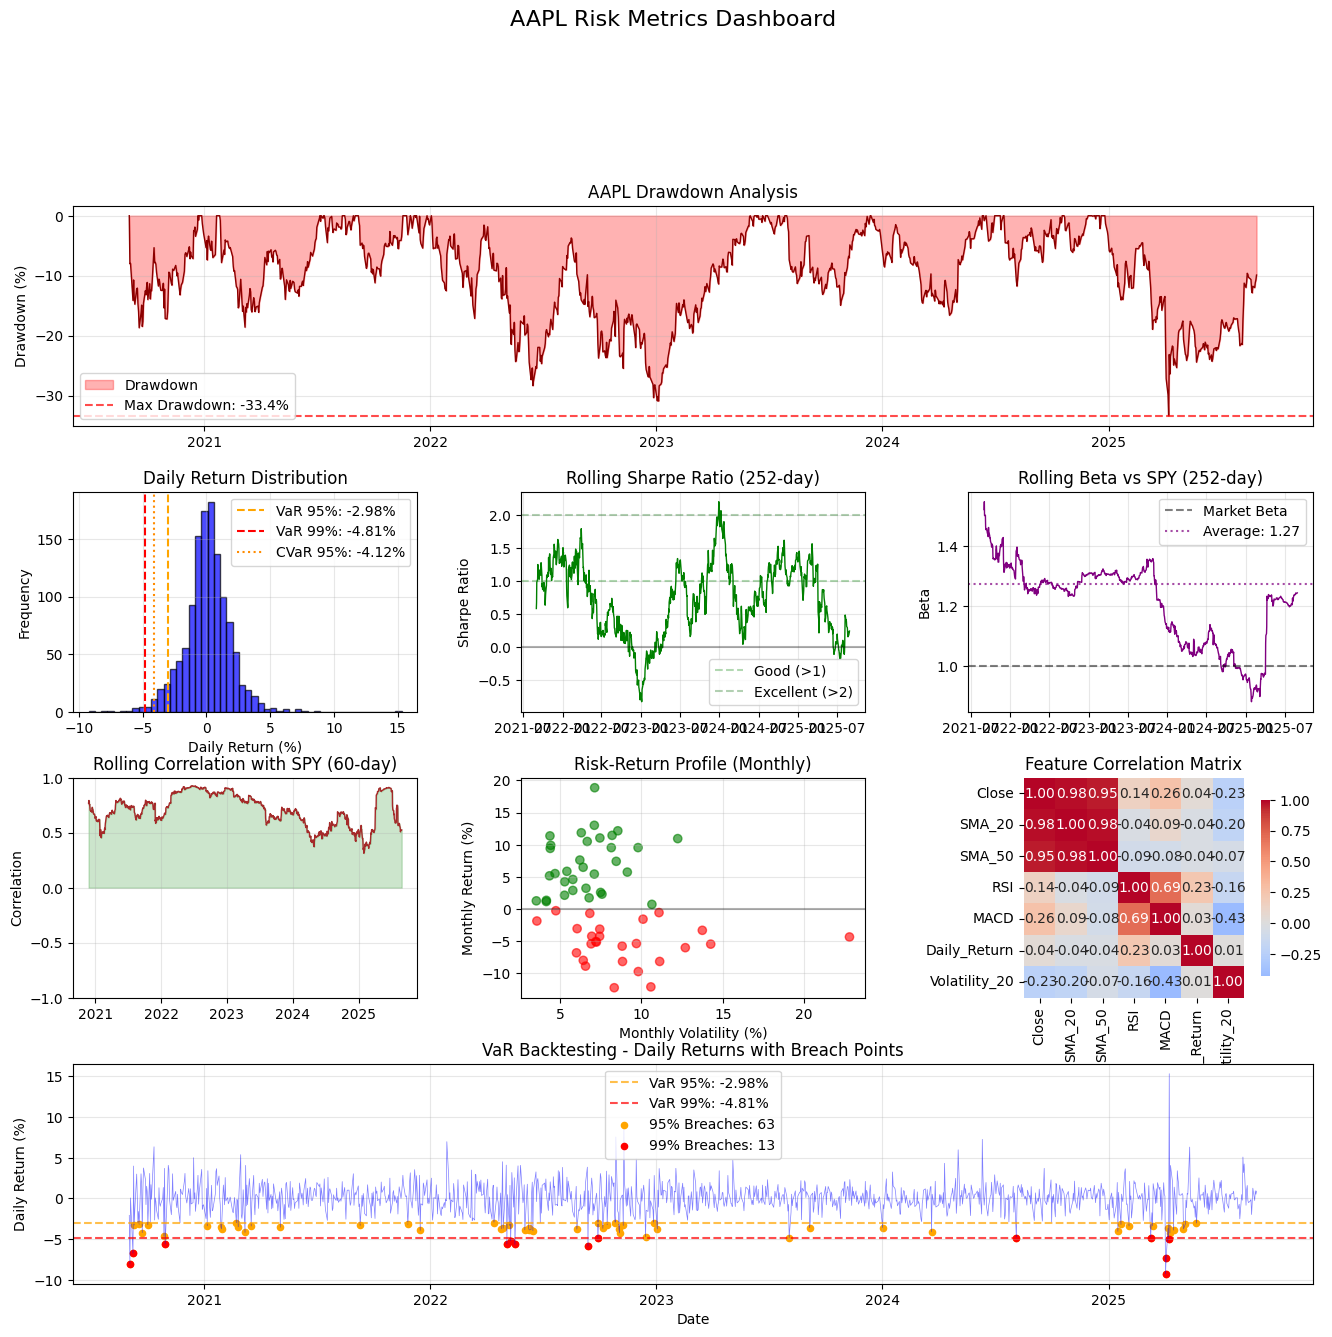


📊 RISK METRICS SUMMARY TABLE
            Metric   Value
           VaR 95%  -2.98%
           VaR 99%  -4.81%
          CVaR 95%  -4.12%
          CVaR 99%  -6.05%
      Max Drawdown -33.36%
              Beta   1.274
      Sharpe Ratio   0.543
     Sortino Ratio   0.543
      Calmar Ratio   0.476
   Ann. Volatility  29.24%
Downside Deviation  20.21%


In [58]:
# Visualize Risk Metrics

fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Drawdown Chart
ax1 = fig.add_subplot(gs[0, :])
ax1.fill_between(hist_data_enhanced.index, 0, hist_data_enhanced['Drawdown'] * 100, 
                  color='red', alpha=0.3, label='Drawdown')
ax1.plot(hist_data_enhanced.index, hist_data_enhanced['Drawdown'] * 100, 
         color='darkred', linewidth=1)
ax1.axhline(y=max_drawdown * 100, color='red', linestyle='--', alpha=0.7, 
            label=f'Max Drawdown: {max_drawdown*100:.1f}%')
ax1.set_title(f'{ticker} Drawdown Analysis')
ax1.set_ylabel('Drawdown (%)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# 2. Return Distribution with VaR/CVaR
ax2 = fig.add_subplot(gs[1, 0])
returns_pct = returns * 100
ax2.hist(returns_pct, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax2.axvline(x=var_95 * 100, color='orange', linestyle='--', label=f'VaR 95%: {var_95*100:.2f}%')
ax2.axvline(x=var_99 * 100, color='red', linestyle='--', label=f'VaR 99%: {var_99*100:.2f}%')
ax2.axvline(x=cvar_95 * 100, color='darkorange', linestyle=':', label=f'CVaR 95%: {cvar_95*100:.2f}%')
ax2.set_title('Daily Return Distribution')
ax2.set_xlabel('Daily Return (%)')
ax2.set_ylabel('Frequency')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(hist_data_enhanced.index, hist_data_enhanced['Rolling_Sharpe'], 
         color='green', linewidth=1)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.axhline(y=1, color='green', linestyle='--', alpha=0.3, label='Good (>1)')
ax3.axhline(y=2, color='darkgreen', linestyle='--', alpha=0.3, label='Excellent (>2)')
ax3.set_title('Rolling Sharpe Ratio (252-day)')
ax3.set_ylabel('Sharpe Ratio')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# 4. Rolling Beta
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(hist_data_enhanced.index, hist_data_enhanced['Rolling_Beta'], 
         color='purple', linewidth=1)
ax4.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Market Beta')
ax4.axhline(y=beta, color='purple', linestyle=':', alpha=0.7, 
            label=f'Average: {beta:.2f}')
ax4.set_title('Rolling Beta vs SPY (252-day)')
ax4.set_ylabel('Beta')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# 5. Rolling Correlation with Market
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(hist_data_enhanced.index, hist_data_enhanced['Rolling_Correlation_SPY'], 
         color='brown', linewidth=1)
ax5.fill_between(hist_data_enhanced.index, 0, hist_data_enhanced['Rolling_Correlation_SPY'],
                  where=(hist_data_enhanced['Rolling_Correlation_SPY'] > 0), 
                  color='green', alpha=0.2)
ax5.fill_between(hist_data_enhanced.index, 0, hist_data_enhanced['Rolling_Correlation_SPY'],
                  where=(hist_data_enhanced['Rolling_Correlation_SPY'] < 0), 
                  color='red', alpha=0.2)
ax5.set_title('Rolling Correlation with SPY (60-day)')
ax5.set_ylabel('Correlation')
ax5.set_ylim(-1, 1)
ax5.grid(True, alpha=0.3)

# 6. Risk-Return Scatter (Monthly)
ax6 = fig.add_subplot(gs[2, 1])
monthly_returns = hist_data_enhanced['Close'].resample('M').last().pct_change()
monthly_vol = hist_data_enhanced['Daily_Return'].resample('M').std() * np.sqrt(21)
colors = np.where(monthly_returns > 0, 'green', 'red')
ax6.scatter(monthly_vol * 100, monthly_returns * 100, c=colors, alpha=0.6)
ax6.set_title('Risk-Return Profile (Monthly)')
ax6.set_xlabel('Monthly Volatility (%)')
ax6.set_ylabel('Monthly Return (%)')
ax6.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax6.grid(True, alpha=0.3)

# 7. Correlation Heatmap
ax7 = fig.add_subplot(gs[2, 2])
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax7, cbar_kws={'shrink': 0.8})
ax7.set_title('Feature Correlation Matrix')

# 8. VaR Backtesting - Fix dimension mismatch
ax8 = fig.add_subplot(gs[3, :])
# Use Daily_Return column directly which has NaN for first row
daily_returns_pct = hist_data_enhanced['Daily_Return'] * 100
ax8.plot(hist_data_enhanced.index, daily_returns_pct, color='blue', alpha=0.5, linewidth=0.5)
ax8.axhline(y=var_95 * 100, color='orange', linestyle='--', alpha=0.7, 
            label=f'VaR 95%: {var_95*100:.2f}%')
ax8.axhline(y=var_99 * 100, color='red', linestyle='--', alpha=0.7, 
            label=f'VaR 99%: {var_99*100:.2f}%')
# Find breaches
breaches_95 = hist_data_enhanced[hist_data_enhanced['Daily_Return'] < var_95]
breaches_99 = hist_data_enhanced[hist_data_enhanced['Daily_Return'] < var_99]
ax8.scatter(breaches_95.index, breaches_95['Daily_Return'] * 100, color='orange', s=20, 
            label=f'95% Breaches: {len(breaches_95)}')
ax8.scatter(breaches_99.index, breaches_99['Daily_Return'] * 100, color='red', s=20, 
            label=f'99% Breaches: {len(breaches_99)}')
ax8.set_title('VaR Backtesting - Daily Returns with Breach Points')
ax8.set_ylabel('Daily Return (%)')
ax8.set_xlabel('Date')
ax8.legend(loc='best')
ax8.grid(True, alpha=0.3)

plt.suptitle(f'{ticker} Risk Metrics Dashboard', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Risk metrics summary table
risk_summary = pd.DataFrame({
    'Metric': ['VaR 95%', 'VaR 99%', 'CVaR 95%', 'CVaR 99%', 'Max Drawdown', 
               'Beta', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio',
               'Ann. Volatility', 'Downside Deviation'],
    'Value': [f'{var_95*100:.2f}%', f'{var_99*100:.2f}%', 
              f'{cvar_95*100:.2f}%', f'{cvar_99*100:.2f}%',
              f'{max_drawdown*100:.2f}%', f'{beta:.3f}',
              f'{sharpe_ratio:.3f}', f'{sortino_ratio:.3f}', f'{calmar_ratio:.3f}',
              f'{returns.std()*np.sqrt(252)*100:.2f}%', f'{downside_deviation*100:.2f}%']
})

print("\n📊 RISK METRICS SUMMARY TABLE")
print("=" * 35)
print(risk_summary.to_string(index=False))